In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import pandas as pd
import pdfplumber
import numpy as np
import joblib
import math
import re
import torch

In [2]:
data = pd.read_csv('dataset.csv')
data = data.drop('Unnamed: 0', axis=1)

In [3]:
data.head(n=5)

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_299,width,height,left_distance,bottom_distance,right_distance,top_distance,fontname,fontsize,label
0,-0.355680,-0.248500,0.32543,-0.038704,0.62980,0.398140,0.23029,0.007171,-0.11763,-0.90891,...,-0.042316,130.392400,45.025,54.050,102.16705,184.442400,57.14205,1,45.025,1
1,1.120200,0.193420,-0.16196,-1.178900,0.44859,0.257830,0.16437,0.263490,-0.60810,2.72750,...,0.386610,154.931025,45.025,199.400,102.16705,354.331025,57.14205,1,45.025,1
2,-0.534460,0.405230,-0.64334,-0.005094,0.49263,-0.360030,0.15781,-0.843470,0.36604,3.82510,...,-0.139580,96.636100,16.225,54.050,120.50725,150.686100,104.28225,2,16.225,6
3,0.079878,0.184400,-0.75717,0.462540,0.64727,-0.142300,0.10444,-0.608470,-0.21654,2.25200,...,0.617300,83.034600,13.800,64.875,181.37700,147.909600,167.57700,3,13.800,1
4,0.049935,-0.096466,-0.27315,-0.243580,0.13666,-0.044576,-0.38256,0.138110,0.66757,-1.22940,...,0.010549,21.858600,10.200,64.875,202.09200,86.733600,191.89200,2,10.200,6


### Transform Input Into Vector
To properly classify the titles of this resume, all words must be vectorized for the ML to best classify the most probable titles within this resume

In [5]:
input_dir = 'Donna_Robbins.pdf'

In [6]:
import spacy
##---Vectorize Model---##
nlp = spacy.load("en_core_web_lg")

##---Get Vector For Word---##
def word_to_vector(word):
    token = nlp(word)
    if token.has_vector:
        return token.vector
    else:
        # fallback for unknown words
        return np.zeros(300)

##---Return Textual Information And Vectorize Words For Title Classification---##
def vectorize_resume():
    resume_data = []
    with pdfplumber.open(f'{input_dir}') as pdf:
        # Loop through each page
        for page in pdf.pages:
            # Store words in page
            words = page.extract_words(extra_attrs=["fontname", "size"])
            for w in words:
                # Store specific attributes from every word and char in the resume page
                resume_data.append({"word": w["text"],
                            "width": w["width"],
                            "height": w["height"],
                            "left_distance": w["x0"], 
                            "bottom_distance": w["bottom"], 
                            "right_distance": w["x1"], 
                            "top_distance": w["top"],
                            "fontname": w["fontname"],
                            "fontsize": w["size"]})
        # Visually store page
        im = pdf.pages[0].to_image(resolution=100)

    # Transform dict to pandas dataframe
    resume_data = pd.DataFrame(resume_data)
    # Rename col
    resume_data['original_word'] = resume_data['word']
    # Add vector to single col for each word
    resume_data['word'] = resume_data['word'].apply(lambda x: word_to_vector(x))
    # Create matrix
    vector_matrix = np.vstack(resume_data['word'].values)
    # Turn matrix into a df
    vector_df = pd.DataFrame(vector_matrix, index=resume_data.index)
    # Rename col names
    vector_df.columns = [f"vec_{i}" for i in range(vector_df.shape[1])]
    # Remove word col
    meta_df = resume_data.drop(columns=['word'])
    # Concatenate data frames
    resume_data_vec = pd.concat([vector_df, meta_df], axis=1)

    # Load Encoder
    encoder = joblib.load('../models/ordinal_encoder.pkl')
    # Encode fontnames into their respective numbers for classification
    resume_data_vec['fontname'] = encoder.transform(resume_data_vec['fontname'])
    return resume_data_vec, im

W0212 15:44:26.207000 24856 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


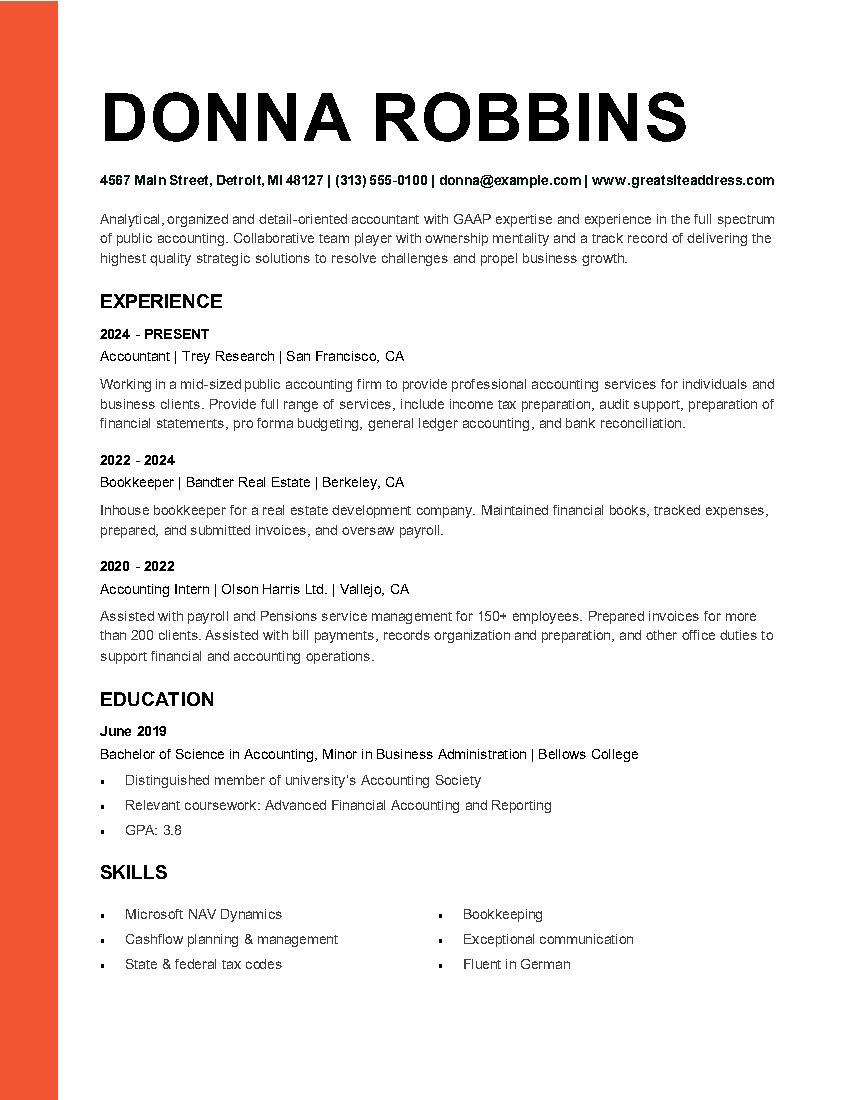

In [7]:
resume_data_vec, im = vectorize_resume()
im

### Train RandomForestClassifier For Resume Title Classification
Training is currently performed through a custom made database of extracted words from multiple resumes

In [9]:
X_train = data.iloc[:, :-1]
y_train = data.iloc[:, -1]

In [10]:
rf = RandomForestClassifier()

In [11]:
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [12]:
filename = '../models/resume_rf_title_classifier.joblib'

joblib.dump(rf, filename)

['../models/resume_rf_title_classifier.joblib']

In [13]:
y_pred = rf.predict(resume_data_vec.iloc[:, :-1])

In [14]:
filename = '../models/resume_label_encoder.pkl'

resume_label_encoder = joblib.load(filename)

In [15]:
y_pred_df = pd.DataFrame(y_pred, columns=['label'])
decoded_labels = resume_label_encoder.inverse_transform(y_pred_df)['label'].values

In [16]:
decoded_labels

array(['PERSONAL', 'PERSONAL', nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, 'EXPERIENCE', nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,